In [1]:
import numpy as np
from sdm_ml.dataset import BBSDataset
from sklearn.preprocessing import StandardScaler
from kernels import ard_rbf_kernel
import matplotlib.pyplot as plt
%matplotlib inline
from sksparse.cholmod import cholesky
import scipy.sparse as sps
from scipy.special import expit

In [2]:
csv_folder = '../../../multi_species/bbs/dataset/csv_bird_data/'
dataset = BBSDataset(csv_folder)

In [3]:
training_set = dataset.get_training_set()

In [4]:
training_set['outcomes'].sum().head()

Anhinga                      32
Double-crested Cormorant    108
American White Pelican       53
Common Merganser             65
Hooded Merganser             19
dtype: int64

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

covariates = scaler.fit_transform(training_set['covariates'].values)
outcomes = training_set['outcomes'][['American Crow', 'Double-crested Cormorant']]

scaler = StandardScaler()

# Keep only the first 200 rows and 2 outcomes for this test
covariates = scaler.fit_transform(covariates.astype(np.float32))[:, :]
outcomes = outcomes.values[:, :2]

y_flat = np.reshape(outcomes, (-1), order='F').astype(float)

/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


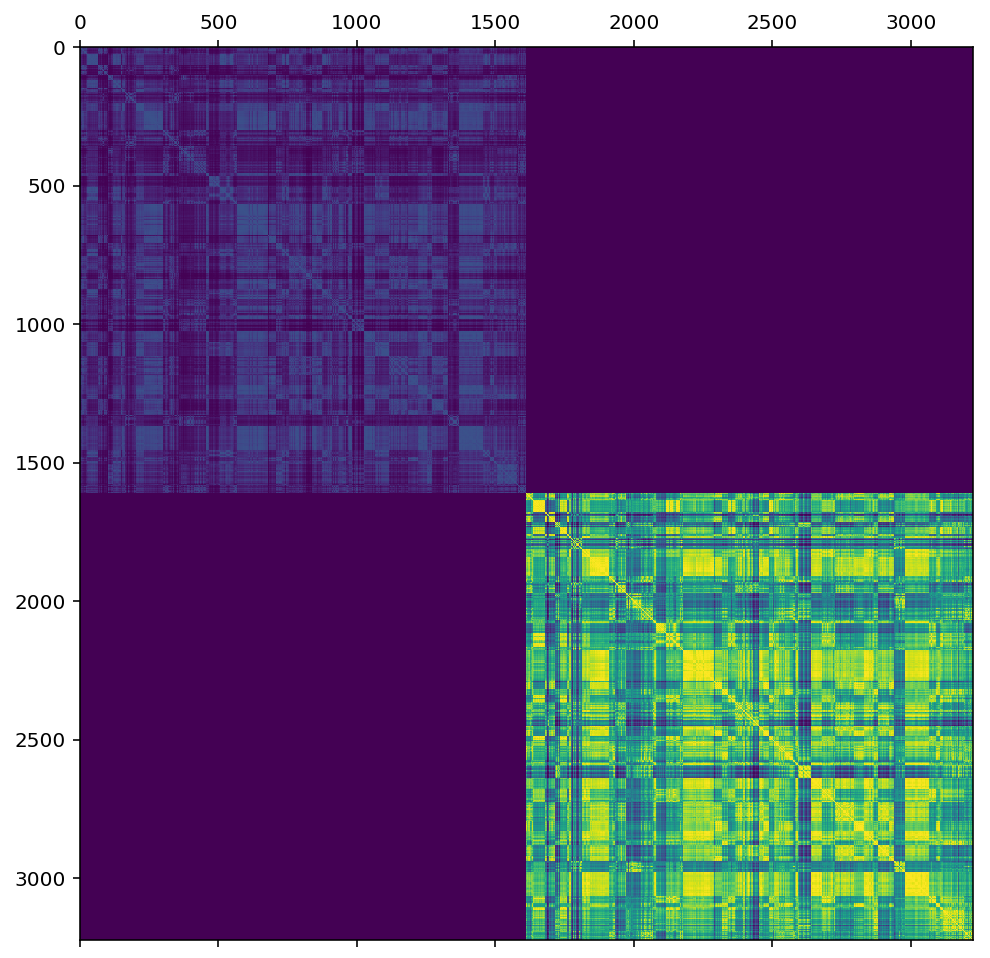

In [6]:
K1 = ard_rbf_kernel(covariates, covariates, np.linspace(2, 4, 8), 1., jitter=1e-5)
K2 = ard_rbf_kernel(covariates, covariates, np.linspace(3, 5, 8), 2., jitter=1e-5)

K = sps.block_diag([K1, K2], format='csc')

#K = sps.csc_matrix(K1)

plt.matshow(K.todense())
plt.gcf().set_size_inches(8, 8)

In [7]:
# Try to follow R & W to the letter

In [8]:
f = np.zeros(K.shape[0])

In [9]:
print('Inverting...')
inv = cholesky(K).solve_A(sps.eye(K.shape[0], format='csc'))
print('Inverted.')

def to_optimise(f):

    probs = expit(f)

    # Calculate log posterior
    log_prior = -0.5 * f.dot(inv.dot(f))
    log_lik = np.sum(probs * y_flat - np.log1p(np.exp(f)))
    log_posterior = log_prior + log_lik

    # First and second derivatives of log likelihood
    grad_log_y = y_flat - probs
    second_log_y = sps.csc_matrix(np.diag(probs * (probs - 1)))

    # First and second derivatives of prior
    grad_prior = -inv.dot(f)
    second_deriv_prior = -inv

    grad_posterior = grad_log_y + grad_prior
    second_deriv_posterior = second_log_y + second_deriv_prior
    
    return {
        'log_post': log_posterior,
        'gradient': grad_posterior,
        'hess': second_deriv_posterior
    }

Inverting...
Inverted.


In [10]:
from scipy.optimize import minimize

fun = lambda x: -to_optimise(x)['log_post']
grad = lambda x: -to_optimise(x)['gradient']
hess = lambda x: -to_optimise(x)['hess'].todense()

result = minimize(fun, x0=np.random.normal(scale=0.1, size=K.shape[0]), jac=grad, hess=hess, method='Newton-CG')

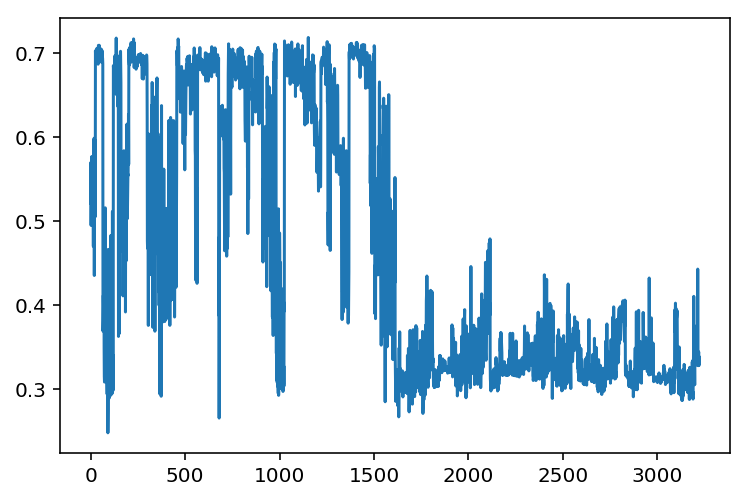

In [12]:
plt.plot(expit(result.x))